https://towardsdatascience.com/time-series-pattern-recognition-with-air-quality-sensor-data-4b94710bb290

# import libraries

In [1]:
%matplotlib inline

import boto3
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import seaborn as sns
import pandas as pd

from sklearn import preprocessing

In [41]:
import warnings
warnings.filterwarnings("ignore")

# import data from AWS

In [8]:
client = boto3.client('iotanalytics')
data = client.get_dataset_content(datasetName='airquality_dataset')
df = pd.read_csv(data["entries"][0]["dataURI"])
df = df[df["timestamp"] > "2021-05-12T00:00:00"]
#df = df[df["timestamp"] > "2021-05-05T00:00:00"] # filter datetime
df.drop("__dt", axis = 1, inplace = True)
df.set_index("timestamp", inplace = True)
df.head()

,temperature,pressure,ppm,humidity
timestamp,,,,
2021-05-19T05:44:25,24.80,996.96,93.7785,34.48
2021-05-19T05:44:30,24.81,996.83,96.4149,34.45
2021-05-19T05:44:35,24.82,996.88,96.4058,34.45
2021-05-19T05:44:40,24.82,996.86,96.3901,34.48
2021-05-19T05:44:45,24.81,996.86,96.4044,34.47


temperature Sample does not look Gaussian (reject H0)
pressure Sample does not look Gaussian (reject H0)
ppm Sample does not look Gaussian (reject H0)
humidity Sample does not look Gaussian (reject H0)


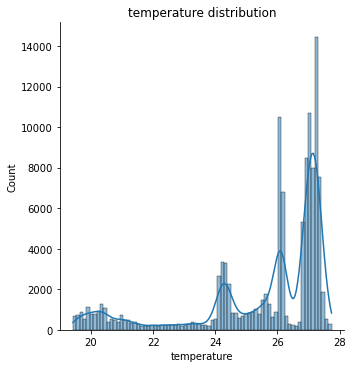

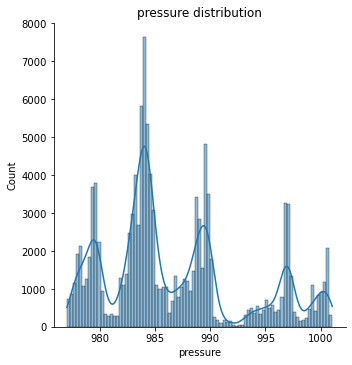

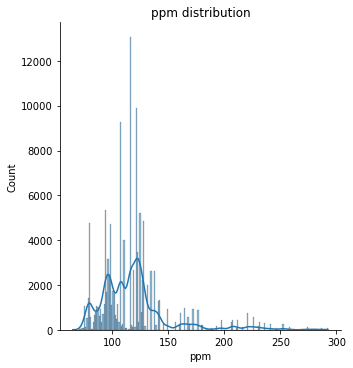

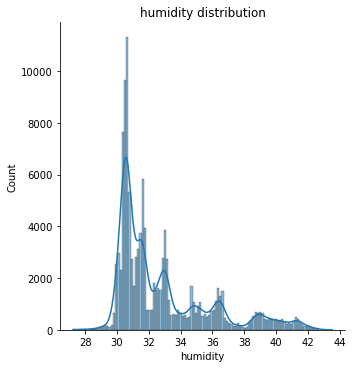

In [55]:
from scipy.stats import shapiro
for column in df.columns:

    sns.displot(x=column, data=df, kde=True).set(title=(str(column)+ " distribution"))

    stat, p = shapiro(df)
    alpha = 0.05
    if p > alpha:
        print(str(column)+ ' Sample looks Gaussian (fail to reject H0)')
    else:
        print(str(column)+' Sample does not look Gaussian (reject H0)')



In [92]:
# roll over x minutes
df_r = df.rolling(12*15)

t = len(df)#12*60*24
df_rm = df_r.mean()[:t]
df_rs = df_r.std()[:t]
df_rupper = df_rm + 1.96*df_rs
df_rlower = df_rm - 1.96*df_rs

df_rmax = df_r.max()[:t]
df_rmin = df_r.min()[:t]

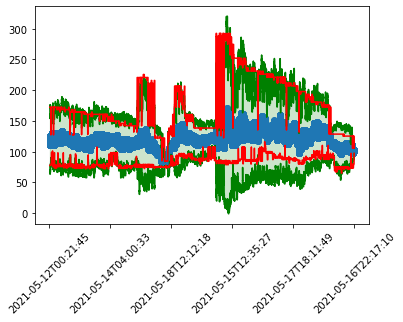

In [93]:
fig, ax = plt.subplots()
plt.fill_between(df_rm.index, df_rupper['ppm'], df_rlower['ppm'], color='g', alpha=0.2)
values = ax.scatter(df_rm.index, 'ppm', data=df_rm)
upper = ax.plot(df_rm.index, 'ppm', data=df_rupper, color="g")
lower = ax.plot(df_rm.index, 'ppm', data=df_rlower, color="g")

ax.plot(df_rm.index, 'ppm', data=df_rmax, color="r")
ax.plot(df_rm.index, 'ppm', data=df_rmin, color="r")



myFmt = mdates.DateFormatter('%d')
ax.xaxis.set_major_formatter(myFmt)

i = int(len(df_rm)/5)

pos = np.arange(len(df_rm.index))
ticks = plt.xticks(pos[::i], df_rm.index.values[::i], rotation=45)

plt.show()

In [ ]:
df = df[:200]
df

fig, ax = plt.subplots()
ax.plot(df.index, 'temperature', data=df)

ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
ax.xaxis.set_minor_locator(mdates.MinuteLocator(interval=0))
ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(mdates.AutoDateLocator()))

In [ ]:
ax = plt.gca()
plt.plot(df.index, df["temperature"])
ax.set_xlabel("Date")

In [ ]:
plt.plot(df.index, df["ppm"])

In [ ]:
column_names_to_normalize = ["ppm", "temperature", "pressure", "humidity"]
df_normalized = df
x = df[column_names_to_normalize].values
x_scaled = min_max_scaler.fit_transform(x)
df_temp = pd.DataFrame(x_scaled, columns=column_names_to_normalize, index = df.index)
df_normalized[column_names_to_normalize] = df_temp

df.head()

In [ ]:
df_r = df_normalized.rolling(360)

df_rm = df_r.mean()
df_rs = df_r.std()
df_rmax = df_r.max()
df_rmin = df_r.min()

In [ ]:
df_normalized.plot.scatter(x="timestamp",y = "ppm")
df_rm["ppm"].plot()
(df_rm["ppm"]+df_rs["ppm"]).plot()
(df_rm["ppm"]-df_rs["ppm"]).plot()


# detect anomalies

## point anomalie detection

In [197]:
def is_outlier(data, rolling_median, thresh):
    return abs(data - rolling_median) >= thresh

In [198]:
# Label the outliers
tresh = 0.17
df_nrm = df.rolling(120, center=True).median()
labels = is_outlier(df, df_nrm5, tresh).astype('int')